In this blog post, I will use a telecommunications dataset for predicting customer churn.   

# Data
Telco Churn is a hypothetical dataset that pertains to a telecommunications company's efforts to minimize the number of customers leaving its services. The dataset has a separate record for each customer, which includes various demographic and service usage information. I have sourced this dataset from "IBM Business Analytics."

The dataset contains information on the following:

* Customers who have discontinued the services within the last month are recorded under the column called "Churn."
* Services that each customer has subscribed to, including phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies.
* Customer account information such as the duration of their association with the company, the type of contract they have signed up for, payment method, paperless billing, monthly charges, and the total charges incurred.
* Demographic information about customers, including their gender, age range, and whether they have partners and dependents.

In [34]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/rtava/MLProject/master/posts/Logistic_Regrssion/ChurnData.csv")


I will choose some featurse that are more related to consumer behaviour.   

|Variable name |Description| 
|:-----|:-----|
|tenure |Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.|
|age|Age of a costumer|
|address|a code that identify the location of a costumer |
|income|costumers income  |
|ed|costumers education levels |
|employ, equip, callcard, and wireless|types of rigestered services|
|churn|a dummy variable that indicates whether a costumer churn or not. |

In [35]:
df = df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip',   'callcard', 'wireless','churn']]
df.head(10)

,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
0,11,33,7,136,5,5,0,1,1,1
1,33,33,12,33,2,0,0,0,0,1
2,23,30,9,30,1,2,0,0,0,0
3,38,35,5,76,2,10,1,1,1,0
4,7,35,14,80,2,15,0,1,0,0
5,68,52,17,120,1,24,0,1,0,0
6,42,40,7,37,2,8,1,1,1,0
7,9,21,1,17,2,2,0,0,0,0
8,35,50,26,140,2,21,0,1,0,0
9,49,51,27,63,4,19,0,1,0,0


In [36]:
print("This dataset has", df.shape[0], "records with", df.shape[1], "atributes")
print("About", df.churn.mean().round(2) , "of costumers chruned") 

This dataset has 400 records with 10 atributes
About 0.29 of costumers chruned


## Descriptive Statistics

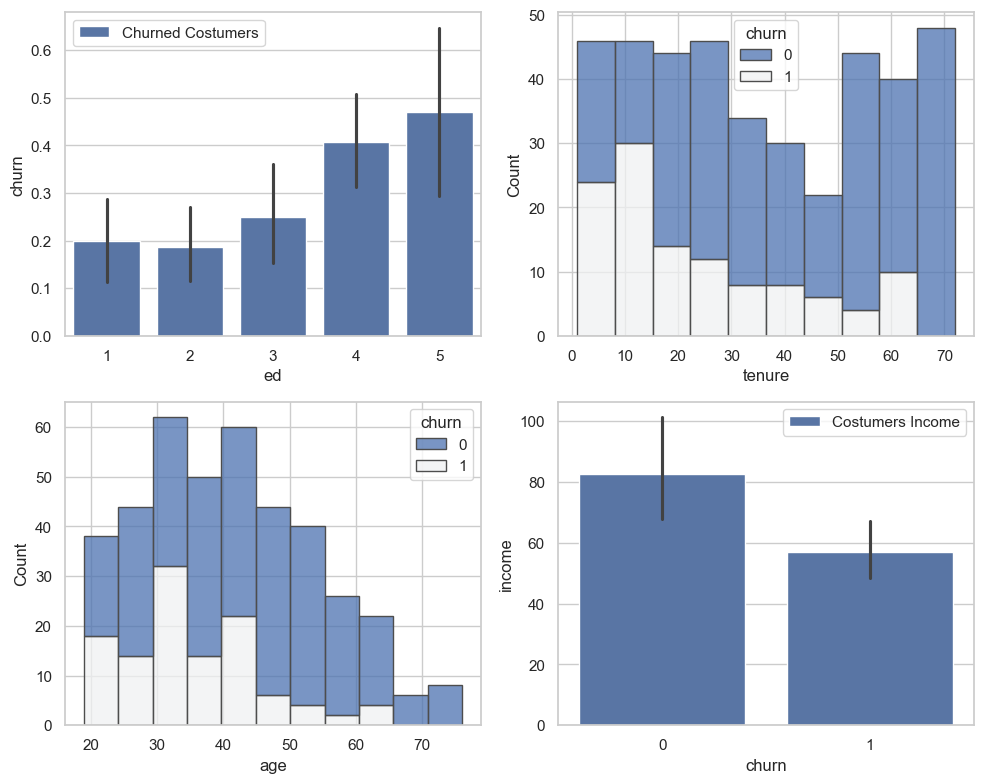

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
ax1, ax2, ax3, ax4 = axes.flatten()

sns.barplot(data=df, x="ed", y="churn", 
            label="Churned Costumers", 
            color="b", ax=ax1)

sns.histplot(data=df, x='tenure', hue='churn',
             color="b", palette="light:b_r",
             multiple="stack" ,edgecolor=".3", ax=ax2)

sns.histplot(data=df, x='age', hue='churn',
             color="b", palette="light:b_r",
             multiple="stack",edgecolor=".3", ax=ax3)

sns.barplot(data=df,x="churn", y="income", 
            label="Costumers Income", color="b", ax=ax4)

plt.tight_layout()
plt.show();

### Correlation between variabeles 

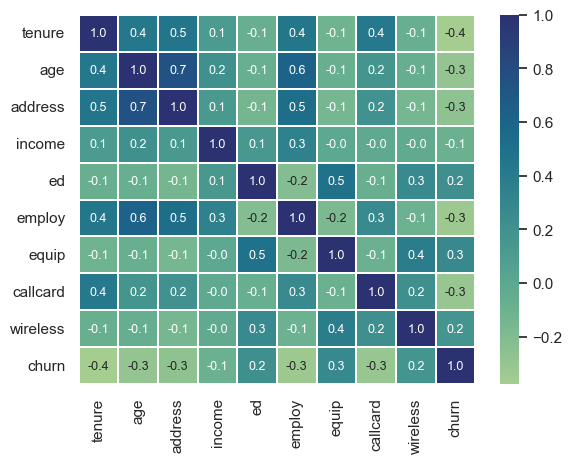

In [38]:
corr = df.corr(method = 'pearson')
sns.heatmap(corr,fmt=".1f", linewidth=.2, cmap="crest", annot=True, annot_kws={"size": 9});

Based on the heat map correlation, I will keep all variables bacause all correlation are less than 80%. But I will scale my data by removing the mean and scaling to unit variance. 

In [39]:
x_col = ['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip',
       'callcard', 'wireless']

In [40]:
from sklearn import preprocessing
df[x_col] = preprocessing.StandardScaler().fit(df[x_col]).transform(df[x_col])

# Logistic Regression Model

In [41]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state = 48)

X_train, y_train = df_train[x_col], df_train['churn']
X_test, y_test = df_test[x_col], df_test['churn']

print("Train Sample Size:", X_train.shape[0],
      "\nTest Sample Size:", X_test.shape[0])

Train Sample Size: 320 
Test Sample Size: 80


In [58]:
from sklearn.linear_model import LogisticRegression

threshold = 0.50
LR = LogisticRegression(C=0.01, solver="liblinear").fit(X_train,y_train)
yhat_LR = LR.predict(X_test)
y_prob_LR = LR.predict_proba(X_test)
y_pred_LR = (y_prob_LR[:,1] >= threshold).astype('int')

## Model Evaluation

In [59]:
from sklearn import metrics

Accuracy_RF = metrics.accuracy_score(y_test, y_pred_LR)
F1_RF = metrics.f1_score(y_test, y_pred_LR)
AUC = metrics.roc_auc_score(y_test, y_pred_LR)
clas_report = metrics.classification_report(y_test, y_pred_LR)

print("RF Accuracy: %0.2f" % (Accuracy_RF), "\nF1 Score: %0.2f" % (F1_RF), "\nAUC_ROC: %0.2f" % (AUC))

RF Accuracy: 0.84 
F1 Score: 0.71 
AUC_ROC: 0.80


### Confusion Matrix

<Axes: >

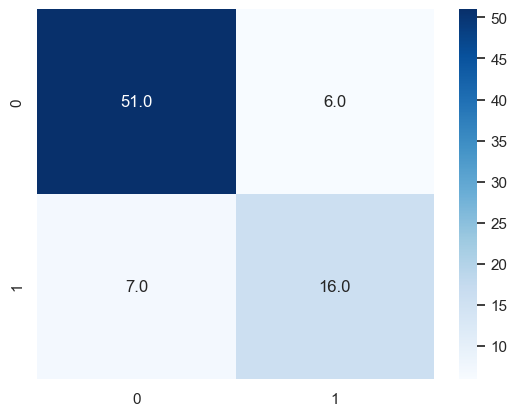

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cf_matrix = confusion_matrix(y_test, y_pred_LR)
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='0.1f')

In [61]:
from sklearn.metrics import log_loss
log_loss(y_test, y_prob_LR)

0.5073750448656873